In [1]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sent-with-data/INTC_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/MSFT_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/IBM_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/GS_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/BA_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/WMT_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/CSCO_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/KO_twitter_refined.csv
/kaggle/input/twitter-sent-with-data/VZ_twitter_refined.csv
/kaggle/input/ntlk-merged/VZ_ntlk.csv
/kaggle/input/ntlk-merged/KO_ntlk.csv
/kaggle/input/ntlk-merged/BA_ntlk.csv
/kaggle/input/ntlk-merged/IBM_ntlk.csv
/kaggle/input/ntlk-merged/INTC_ntlk.csv
/kaggle/input/ntlk-merged/GS_ntlk.csv
/kaggle/input/ntlk-merged/MSFT_ntlk.csv
/kaggle/input/ntlk-merged/WMT_ntlk.csv
/kaggle/input/ntlk-merged/CSCO_ntlk.csv


In [2]:
path = '../input/ntlk-merged/WMT_ntlk.csv'
df = pd.read_csv(path,  
                 low_memory=False, na_values=['nan','?'])
stock = 'Walmart'

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
df.columns

Index(['Date', 'Close', 'Volume', 'anger', 'fear', 'negative', 'positive',
       'sadness', 'trust', 'anticipation', 'joy', 'disgust', 'surprise',
       'anticip', 'word_count'],
      dtype='object')

In [6]:
df

,Close,Volume,anger,fear,negative,positive,sadness,trust,anticipation,joy,disgust,surprise,anticip,word_count
0,45.119999,15118000.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,7.0
1,49.020000,9484700.0,0.00000,0.000000,0.013889,0.013889,0.00000,0.013889,0.013889,0.013889,0.00000,0.013889,0.0,12.0
2,49.360001,8307600.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,11.0
3,53.110001,7373300.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,5.0
4,52.709999,7379300.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,58.049999,15566400.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,12.0
660,58.290001,13924600.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.037037,0.000000,0.00000,0.000000,0.0,10.0
661,59.130001,10271900.0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,13.0
662,59.439999,10283700.0,0.00641,0.012821,0.006410,0.022727,0.00641,0.000000,0.022727,0.000000,0.00641,0.000000,0.0,12.0


In [7]:

values = df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[15,16,17,18,19,20,21,22,23,24,25,26,27]], axis=1, inplace=True)
reframed


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.103768,0.077703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.357143,0.316767
2,0.316767,0.037945,0.000000,0.000000,0.111111,0.111111,0.000000,0.138889,0.125000,0.333333,0.000000,0.305556,0.0,0.714286,0.335336
3,0.335336,0.029637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.642857,0.540142
4,0.540142,0.023043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.214286,0.518296
5,0.518296,0.023086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.214286,0.320044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659,0.885855,0.071814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.476190,0.809940
660,0.809940,0.080868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.714286,0.823048
661,0.823048,0.069281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.0,0.571429,0.868924
662,0.868924,0.043501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.785714,0.885855


In [8]:
len(reframed)*0.8

# split into train and test sets
values = reframed.values

n_train_time = int(len(values)*0.8)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [9]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(530, 1, 14) (530,) (133, 1, 14) (133,)


Epoch 1/22
67/67 - 3s - loss: 0.0451 - val_loss: 0.1206
Epoch 2/22
67/67 - 0s - loss: 0.0254 - val_loss: 0.0898
Epoch 3/22
67/67 - 0s - loss: 0.0180 - val_loss: 0.0548
Epoch 4/22
67/67 - 0s - loss: 0.0136 - val_loss: 0.0302
Epoch 5/22
67/67 - 0s - loss: 0.0100 - val_loss: 0.0166
Epoch 6/22
67/67 - 0s - loss: 0.0073 - val_loss: 0.0076
Epoch 7/22
67/67 - 0s - loss: 0.0053 - val_loss: 0.0037
Epoch 8/22
67/67 - 0s - loss: 0.0044 - val_loss: 0.0023
Epoch 9/22
67/67 - 0s - loss: 0.0036 - val_loss: 0.0017
Epoch 10/22
67/67 - 0s - loss: 0.0033 - val_loss: 0.0016
Epoch 11/22
67/67 - 0s - loss: 0.0032 - val_loss: 0.0016
Epoch 12/22
67/67 - 0s - loss: 0.0032 - val_loss: 0.0016
Epoch 13/22
67/67 - 0s - loss: 0.0030 - val_loss: 0.0017
Epoch 14/22
67/67 - 0s - loss: 0.0030 - val_loss: 0.0016
Epoch 15/22
67/67 - 0s - loss: 0.0032 - val_loss: 0.0022
Epoch 16/22
67/67 - 0s - loss: 0.0029 - val_loss: 0.0017
Epoch 17/22
67/67 - 0s - loss: 0.0030 - val_loss: 0.0016
Epoch 18/22
67/67 - 0s - loss: 0.0031 - 

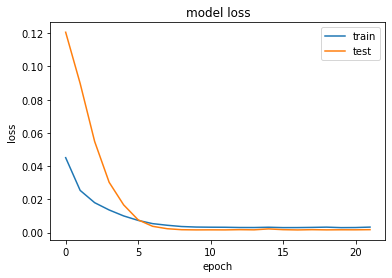

In [10]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=22, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()



In [13]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [22]:
#inv_yhat = np.concatenate((yhat, test_X[:, third_dimesion:]), axis=1)
#inv_yhat.shape

In [23]:
#inv_yhat = scaler.inverse_transform(inv_yhat)

In [24]:


#inv_yhat = inv_yhat[:,0]
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = np.concatenate((test_y, test_X[:, third_dimesion:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]

In [25]:
third_dimesion = test_X.shape[1]-1
third_dimesion = -third_dimesion
third_dimesion

In [ ]:
print('MSE: '+str(min(test_mse)) + ' : '+str(test_mse.index(min(test_mse))))
print('MAE: '+str(min(test_mae)) + ' : '+str(test_mae.index(min(test_mae))))
print('RMSE: '+str(min(test_rmse)) + ' : '+str(test_rmse.index(min(test_rmse))))
print('MAPE: '+str(min(test_mape)) + ' : '+str(test_mape.index(min(test_mape))))

print(f'{min(test_mape):.6f}')
print(f'{min(test_mae):.6f}')
print(f'{min(test_rmse):.6f}')
print(f'{min(test_mape):.6f}')

In [20]:
#This block of code searching for the best batch size
test_mse = []
test_mae = []
test_rmse = []
test_mape = []
for fuck in range(1,10):
    values = reframed.values
    n_train_time = int(len(values)*0.8)
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(train_X, train_y, epochs=22, batch_size=fuck, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_yhat = np.concatenate((yhat, test_X[:, third_dimesion:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, third_dimesion:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    mse = mean_squared_error(inv_y, inv_yhat)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(inv_y, inv_yhat)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(inv_yhat - inv_y)/np.abs(inv_y))
    print('MAPE: '+str(mape))
    
    test_mse.append(mse) 
    test_mae.append(mae) 
    test_rmse.append(rmse)
    test_mape.append(mape)

(530, 1, 14) (530,) (133, 1, 14) (133,)
Epoch 1/22
530/530 - 3s - loss: 0.0137 - val_loss: 0.0089
Epoch 2/22
530/530 - 1s - loss: 0.0066 - val_loss: 0.0061
Epoch 3/22
530/530 - 1s - loss: 0.0046 - val_loss: 0.0052
Epoch 4/22
530/530 - 1s - loss: 0.0044 - val_loss: 0.0069
Epoch 5/22
530/530 - 1s - loss: 0.0040 - val_loss: 0.0032
Epoch 6/22
530/530 - 1s - loss: 0.0039 - val_loss: 0.0060
Epoch 7/22
530/530 - 1s - loss: 0.0038 - val_loss: 0.0056
Epoch 8/22
530/530 - 1s - loss: 0.0037 - val_loss: 0.0031
Epoch 9/22
530/530 - 1s - loss: 0.0035 - val_loss: 0.0025
Epoch 10/22
530/530 - 1s - loss: 0.0034 - val_loss: 0.0039
Epoch 11/22
530/530 - 1s - loss: 0.0035 - val_loss: 0.0053
Epoch 12/22
530/530 - 1s - loss: 0.0033 - val_loss: 0.0087
Epoch 13/22
530/530 - 1s - loss: 0.0035 - val_loss: 0.0037
Epoch 14/22
530/530 - 1s - loss: 0.0033 - val_loss: 0.0038
Epoch 15/22
530/530 - 1s - loss: 0.0035 - val_loss: 0.0036
Epoch 16/22
530/530 - 1s - loss: 0.0034 - val_loss: 0.0050
Epoch 17/22
530/530 - 1s 

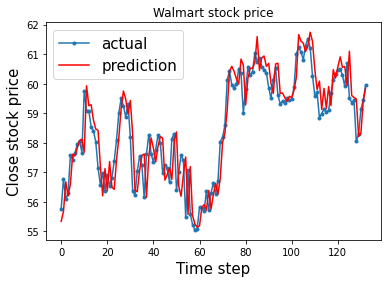

In [21]:
## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(len(inv_yhat))]
plt.plot(aa, inv_y[:len(inv_yhat)], marker='.', label="actual")
plt.plot(aa, inv_yhat[:len(inv_yhat)], 'r', label="prediction")
plt.ylabel('Close stock price', size=15)
plt.xlabel('Time step', size=15)
plt.title(stock+' stock price')
plt.legend(fontsize=15)
plt.show()